In [1]:
import matplotlib.pyplot as plt
from pydy.viz import Sphere, Cylinder, VisualizationFrame, Scene
from scipy.integrate import odeint

from src.robotmodel import *

/home/guy/code/2d-robot-prognostics/.venv/lib/python3.8/site-packages/sympy/printing/ccode.py:8: SymPyDeprecationWarning: 

importing from sympy.printing.ccode has been deprecated since SymPy
1.7. Use Import from sympy.printing.c instead. See
https://github.com/sympy/sympy/issues/20256 for more info.

  SymPyDeprecationWarning(


# Constants

In [2]:
SIMULATION_TIME = 10.0
SIMULATION_TIME_STEP = 0.01

upper_arm_radius_constant = 0.054
upper_arm_mass_constant = 8.393
fore_arm_length_constant = 0.392  # todo quick hack
fore_arm_radius_constant = 0.060
fore_arm_mass_constant = 2.275

# https://github.com/ros-industrial/universal_robot/blob/kinetic-devel/ur_e_description/urdf/ur5e.urdf.xacro
kane_sys.constants = {
    upper_arm_length: 0.425,  # [m]
    upper_arm_com_length: 0.2125,  # [m]
    upper_arm_mass: 8.393,  # [kg]
    # [kg*m^2]
    upper_arm_inertia: 0.5 * upper_arm_mass_constant * upper_arm_radius_constant ** 2,
    # fore_arm_length: 0.392,  # [m]
    fore_arm_com_length: 0.11993,  # [m]
    fore_arm_mass: fore_arm_mass_constant,  # [kg]
    # [kg*m^2]
    fore_arm_inertia: 0.5 * fore_arm_mass_constant * fore_arm_radius_constant ** 2,
    g: 9.806
}

# Setup

In [3]:
times = np.arange(0.0, SIMULATION_TIME, SIMULATION_TIME_STEP)
initial_conditions = [
    3.0,    # theta1 shoulder angle
    -1.0,   # theta2 elbow angle
    0.0,    # omega1 shoulder speed
    0.0,    # omega2 shoulder angle
]

shoulder_shape = Cylinder(
    name='shoulder', color='grey', radius=0.06, length=0.13)
elbow_shape = Cylinder(name='elbow', color='grey', radius=0.06, length=0.13)

shoulder_viz_frame = VisualizationFrame(
    'shoulder', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), shoulder, shoulder_shape)
elbow_viz_frame = VisualizationFrame(
    'elbow', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), elbow, elbow_shape)

upper_arm_center = Point('l_c')
fore_arm_center = Point('u_c')

upper_arm_center.set_pos(
    shoulder, kane_sys.constants[upper_arm_length]/2 * upper_arm_frame.y)
fore_arm_center.set_pos(elbow, fore_arm_length_constant/2 * fore_arm_frame.y)

upper_arm_shape = Cylinder(name='upper arm',
                           radius=upper_arm_radius_constant,
                           length=kane_sys.constants[upper_arm_length],
                           color='lightskyblue')

fore_arm_shape = Cylinder(name='fore arm',
                          radius=fore_arm_radius_constant,
                          length=fore_arm_length_constant,
                          color='lightskyblue')

upper_arm_viz_frame = VisualizationFrame('Upper Arm', upper_arm_frame,
                                         upper_arm_center, upper_arm_shape)

fore_arm_viz_frame = VisualizationFrame('Fore Arm', fore_arm_frame,
                                        fore_arm_center, fore_arm_shape)

Text(0, 0.5, 'angle (rad,rad/s)')

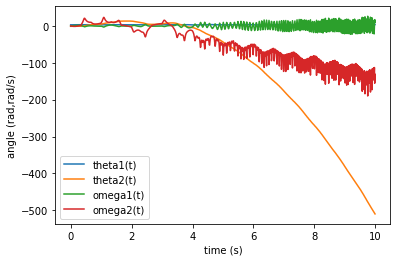

In [4]:
from scipy import signal, interpolate

t = times
freq = 1.5  # Hz
amp = 3
center = 0.5
square_wave_data = center + (amp / 2) * signal.square(2 * np.pi * freq * t)
square_wave = interpolate.interp1d(t,square_wave_data, fill_value="extrapolate")

# plt.plot(t, square_wave(t))

# plt.ylim(-2, 2)
# plt.title("1 Hz Square Wave")

def controller(x, t):
    T_s = -square_wave(t)
    T_e = square_wave(t)
    return (T_s, T_e) #u The specified inputs are, in order: T_s(t), T_e(t)

y = odeint(kane_sys.generate_ode_function(), initial_conditions, times, args=(controller,kane_sys.constants))

plt.plot(times,y)
plt.legend(kane_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')


In [5]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                            upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = kane_sys.constants
scene.states_trajectories = y
scene.times = times
# scene.display_jupyter()

In [6]:
from src.controller import build_optimal_controller


equilibrium_point = np.zeros(len(coordinates + speeds))
equilibrium_dict = dict(zip(coordinates + speeds, equilibrium_point))

r = np.array([[0],[1]]) #two desired angles

K, Nbar = build_optimal_controller(kane, kane_sys.constants, equilibrium_dict)

def controller(x, t):
    u = np.asarray(np.add(-np.matmul(K, x), np.matmul(Nbar,r))).flatten()
    # u = -np.asarray(np.dot(K,x)).flatten()
    return u


/home/guy/code/2d-robot-prognostics/.venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0, 0.5, 'angle (rad,rad/s)')

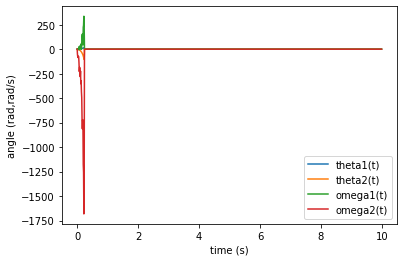

In [7]:
y = odeint(kane_sys.generate_ode_function(), initial_conditions, times, args=(controller,kane_sys.constants))

plt.plot(times,y)
# plt.ylim(-1,1)
plt.legend(kane_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')